# Using residuals to estimate a missing feature

## Set up notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Generate synthetic dataset for classification

In [3]:
# Generate synthetic data set with three features and two classes
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
X_full, y = make_classification(
    n_samples=5000, 
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    class_sep=1,
    random_state=42)

In [4]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size = 0.1)

Get two features, and hold the third one back as 'Z'

In [5]:
X_train = X_train_full[:,0:2]
X_test = X_test_full[:,0:2]
Z_train = X_train_full[:,2]
Z_test = X_test_full[:,2]

## Test model based on all features

In [6]:
# Standardise data
X_train_std, X_test_std = standardise_data(X_train_full, X_test_full)

# Fit model
model = LogisticRegression()
model.fit(X_train_std,y_train)

# Predict training and test set labels
y_pred_test = model.predict(X_test_std)
accuracy = np.mean(y_pred_test == y_test)
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.890


## Test model based on two features

In [7]:
# Standardise data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Fit model
model = sk.linear_model.LogisticRegression()
model.fit(X_train_std,y_train)

# Predict training and test set labels
y_pred_test = model.predict(X_test_std)
accuracy = np.mean(y_pred_test == y_test)
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.668


## Test model where missing data is replaced with residuals from prior model

Get residuals from training set

In [8]:
residuals = y_train - model.predict_proba(X_train_std)[:,1]

Add to two X features

In [9]:
X_train_with_residuals = np.concatenate([X_train, residuals.reshape(-1,1)], axis=1)

Create a new train/test split ( do not reorder values)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_with_residuals, y_train, test_size = 0.2, shuffle=False)

# Get residuals and original Z data for this training set
residuals_train = residuals[0:len(X_train)]
Z_train_short = Z_train[0:len(X_train)]
residual_test = residuals[len(X_train):]
Z_test_short = Z_train[len(X_train):]

Train model and test

In [11]:
# Standardise data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Fit model
model = sk.linear_model.LogisticRegression()
model.fit(X_train_std,y_train)

# Predict training and test set labels
y_pred_test = model.predict(X_test_std)
accuracy = np.mean(y_pred_test == y_test)
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 1.000


Fit a model to two original features

In [12]:
# Fit model to two features
model_2f = sk.linear_model.LogisticRegression()
model_2f.fit(X_train_std[:,0:2], y_train)

# Predict training and test set labels
y_pred_test_2f = model_2f.predict(X_test_std[:,0:2])
accuracy = np.mean(y_pred_test_2f == y_test)
print (f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.670


Compare residuals to missing Z data

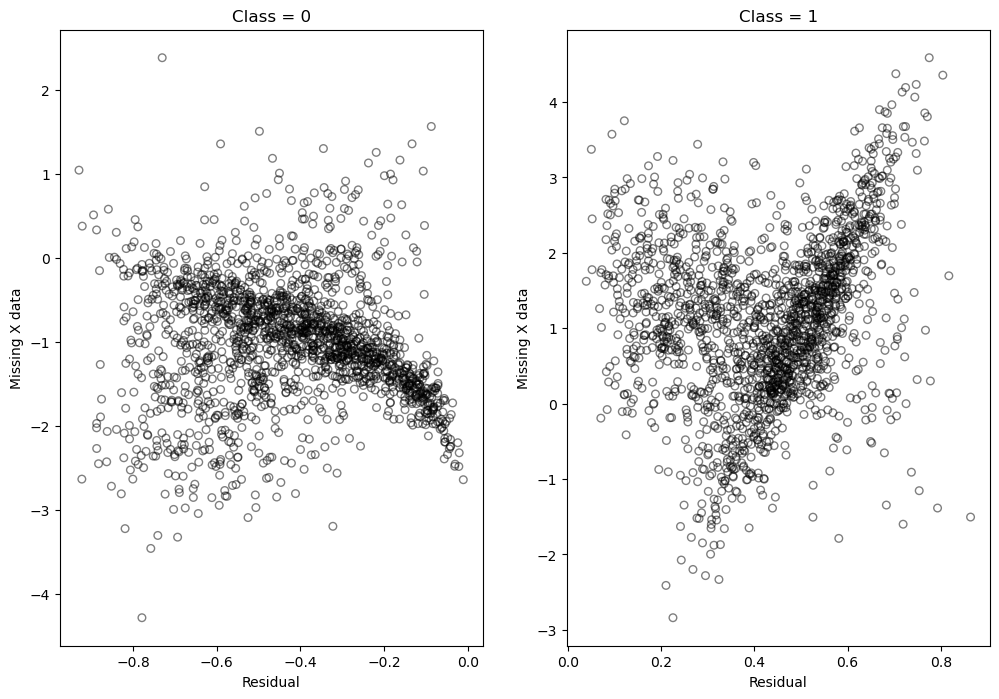

In [13]:
# Fit a regression line to residuals vs Z data
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(residuals_train, Z_train_short) #x,y
r_square = r_value ** 2
y_pred = intercept + (residuals * slope)

# Plot
fig = plt.figure(figsize=(12,8))

##### Class 0
ax1 = fig.add_subplot(1,2,1)
mask = y_train == 0
x = residuals_train[mask]
y = Z_train_short[mask]

ax1.scatter(x, y, s=30, facecolors='none', edgecolors='k', alpha=0.5)
ax1.set_title('Class = 0')
ax1.set_xlabel('Residual')
ax1.set_ylabel('Missing X data')

##### Class 1
ax2 = fig.add_subplot(1,2,2)
mask = y_train == 1
x = residuals_train[mask]
y = Z_train_short[mask]

ax2.scatter(x, y, s=30, facecolors='none', edgecolors='k', alpha=0.5)
ax2.set_title('Class = 1')
ax2.set_xlabel('Residual')
ax2.set_ylabel('Missing X data')

plt.show()

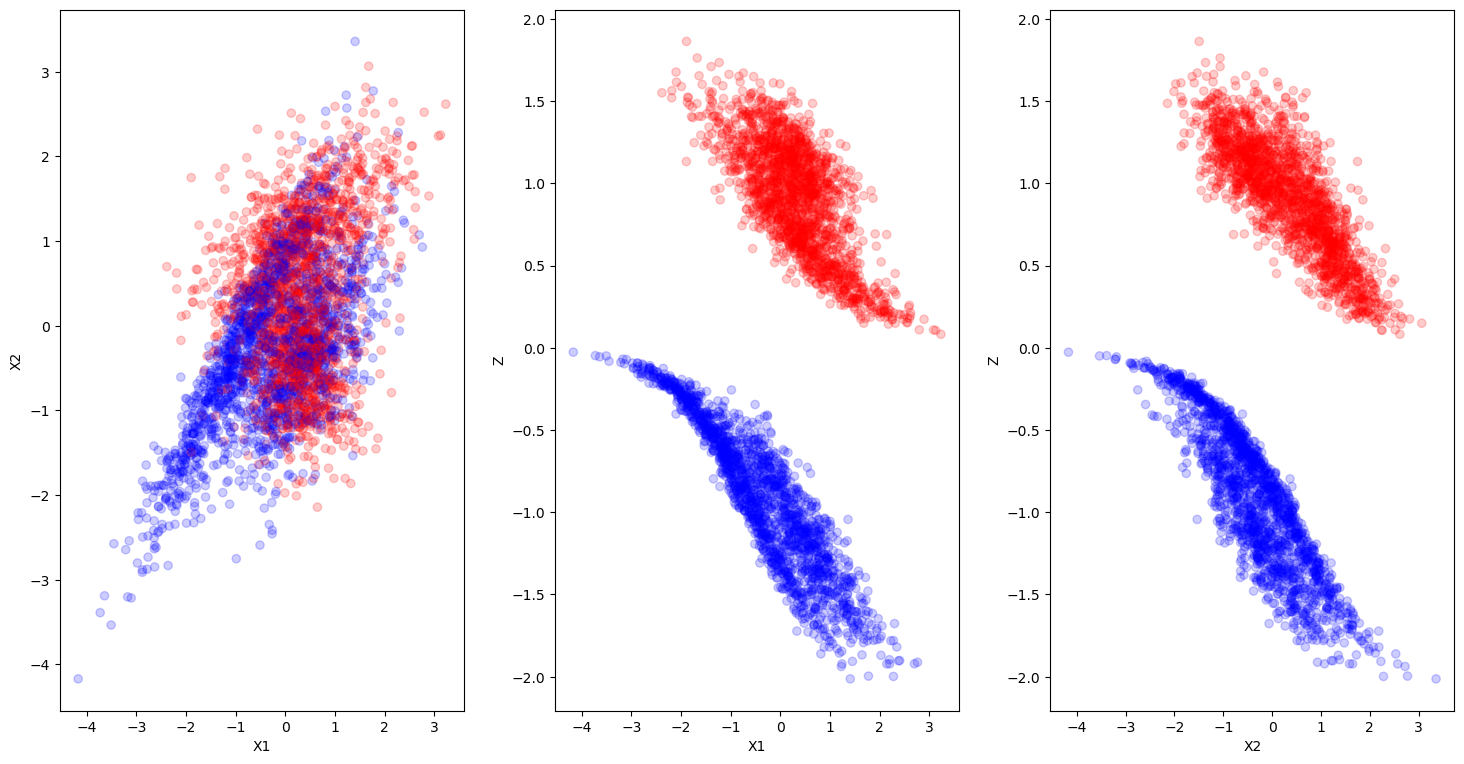

In [14]:
colors={0:'b', 1:'r'}

# Plot
fig = plt.figure(figsize=(15,8))

# X1 vs X2
x = X_train_std[:, 0]
y = X_train_std[:, 1]
colors = [colors[c] for c in list(y_train)]
ax1 = fig.add_subplot(1,3,1)
ax1.scatter(x, y , c=colors, alpha=0.2)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')

# X1 vs Z
x = X_train_std[:, 0]
y = X_train_std[:, 2]
ax2 = fig.add_subplot(1,3,2)
ax2.scatter(x, y , c=colors, alpha=0.2)
ax2.set_xlabel('X1')
ax2.set_ylabel('Z')

# X2 vs Z
x = X_train_std[:, 1]
y = X_train_std[:, 2]
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(x, y , c=colors, alpha=0.2)
ax3.set_xlabel('X2')
ax3.set_ylabel('Z')

plt.tight_layout(pad=2)
plt.show()